In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data1 = pd.read_csv('../prices/prices_round_2_day_-1.csv', header = 0, sep=";")
data2 = pd.read_csv('../prices/prices_round_2_day_0.csv', header = 0, sep=";")
data3 = pd.read_csv('../prices/prices_round_2_day_1.csv', header = 0, sep=";")

# Join rows of data1, data2 and data3
data = pd.concat([data1, data2, data3]).reset_index(drop=True)
data.head()

,timestamp,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY
0,0,1200.00,1.5,10.5,-2.0,2500.0000,79.00000,-1
1,100,1201.75,1.5,9.5,-2.0,2499.4197,79.00410,-1
2,200,1201.75,1.5,9.5,-2.0,2498.8457,79.00821,-1
3,300,1201.75,1.5,9.5,-2.0,2498.2780,79.01234,-1
4,400,1201.75,1.5,9.5,-2.0,2497.7166,79.01649,-1


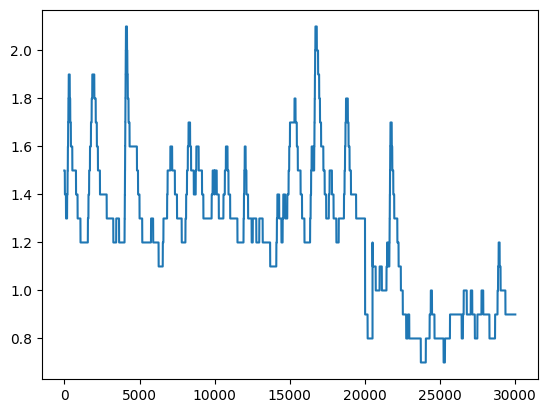

[0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1]


1.2370429623704295

In [10]:
plt.plot(data['TRANSPORT_FEES'])
plt.show()
print(np.unique(data['TRANSPORT_FEES']))
np.mean(data['TRANSPORT_FEES'])

In [36]:
data_submission = pd.read_csv('../prices/submission_round_2.csv', header = 0, sep=";")
data_submission.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,AMETHYSTS,9998,3,9996.0,1.0,9995.0,21.0,10004,1,10005.0,21.0,NaN,NaN,10001.0,0.0
1,1,0,ORCHIDS,1094,10,1093.0,3.0,1086.0,41.0,1102,10,1104.0,3.0,1111.0,41.0,1098.0,0.0
2,1,0,STARFRUIT,5048,1,5047.0,22.0,NaN,NaN,5054,22,NaN,NaN,NaN,NaN,5051.0,0.0
3,1,100,STARFRUIT,5047,26,NaN,NaN,NaN,NaN,5052,5,5054.0,26.0,NaN,NaN,5049.5,0.0
4,1,100,ORCHIDS,1094,6,1093.0,2.0,1087.0,51.0,1102,6,1103.0,2.0,1110.0,51.0,1098.0,0.0


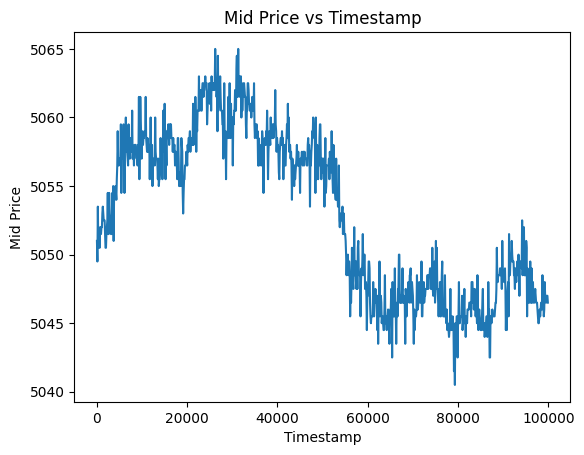

In [37]:
starfruit_rows = data_submission[data_submission['product'] == 'STARFRUIT']
import matplotlib.pyplot as plt

plt.plot(starfruit_rows['timestamp'], starfruit_rows['mid_price'])
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.title('Mid Price vs Timestamp')
plt.show()


MSE: 109.74563953488372, R^2: 0.9847046455269707


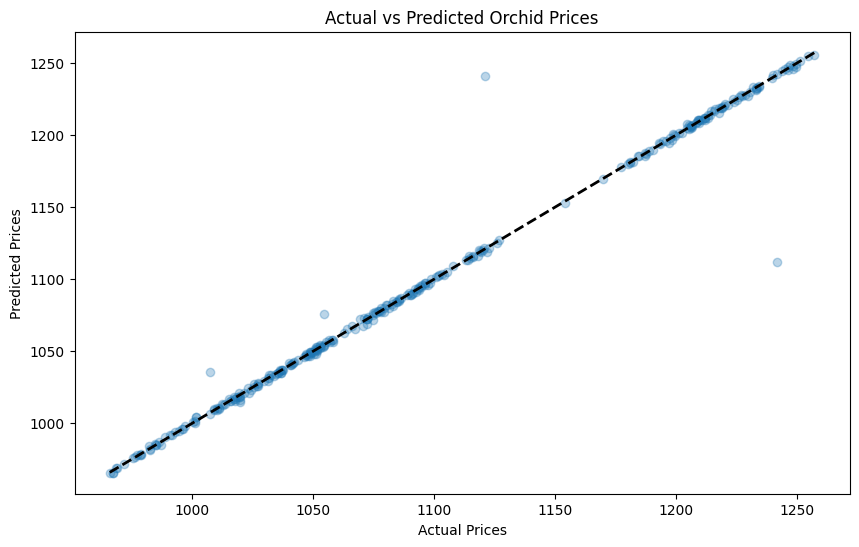

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to load and prepare the dataset
def prepare_dataset(file_path):
    data = pd.read_csv(file_path, header = 0, sep=";")
    return data[['SUNLIGHT', 'HUMIDITY', 'ORCHIDS']]

file_paths = [
    '../prices/prices_round_2_day_-1.csv',
    '../prices/prices_round_2_day_0.csv',
    '../prices/prices_round_2_day_1.csv'
]

# Loading, preparing and combining the datasets
datasets = [prepare_dataset(path) for path in file_paths]
combined_data = pd.concat(datasets)

# Splitting the data into training and validation sets
X = combined_data[['SUNLIGHT', 'HUMIDITY']]
y = combined_data['ORCHIDS']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=42)

# Training the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=1, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the validation set
y_pred = rf_model.predict(X_val)

# Calculating metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'MSE: {mse}, R^2: {r2}')

# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Orchid Prices')
plt.show()

In [39]:
def extract_rules(tree):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    children_left = tree_.children_left
    children_right = tree_.children_right
    value = tree_.value

    rules = {
        'left_children': children_left,
        'right_children': children_right,
        'feature': feature,
        'threshold': threshold,
        'value': value
    }
    return rules

# Extract rules from each tree in the forest
forest_rules = [extract_rules(estimator) for estimator in rf_model.estimators_]

import jsonpickle
encoded = jsonpickle.encode(forest_rules)

with open("Output.txt", "w") as text_file:
    text_file.write(encoded)

In [40]:
def predict_forest(forest_rules, instances):
    def predict_single_tree(rules, instance):
        node = 0
        while rules['feature'][node] != -2:  # -2 indicates a leaf node
            if instance[rules['feature'][node]] <= rules['threshold'][node]:
                node = rules['left_children'][node]
            else:
                node = rules['right_children'][node]
        return np.mean(rules['value'][node])

    predictions = []
    for instance in instances:
        # Average predictions from all trees
        preds = [predict_single_tree(rules, instance) for rules in forest_rules]
        predictions.append(np.mean(preds))
    return predictions

# Example prediction
example_instance = X.to_numpy()[0:1]  # First instance from the dataset
print(example_instance)
predictions = predict_forest(forest_rules, example_instance)
print(predictions)


[[2500.   79.]]
[1200.0]


In [6]:
import re
import numpy as np
import jsonpickle

def extract_floats_from_file(file_path):
    # Open and read the text file
    with open(file_path, 'r') as file:
        content = file.read()

    # Find all contents enclosed by '^'
    pattern_enclosed = r'\^([^\^]+)\^'
    enclosed_contents = re.findall(pattern_enclosed, content)

    # Extract floats from each matched content
    float_numbers = []
    pattern_floats = r'[-+]?[0-9]*\.?[0-9]+'
    for item in enclosed_contents:
        floats = re.findall(pattern_floats, item)
        float_numbers.extend(floats)

    # Convert list of string floats to real floats
    float_numbers = [float(num) for num in float_numbers]

    # Convert list of floats to a NumPy array
    np_array = np.array(float_numbers)

    return np_array

# Example usage
file_path = 'file.txt'
result_array = extract_floats_from_file(file_path)

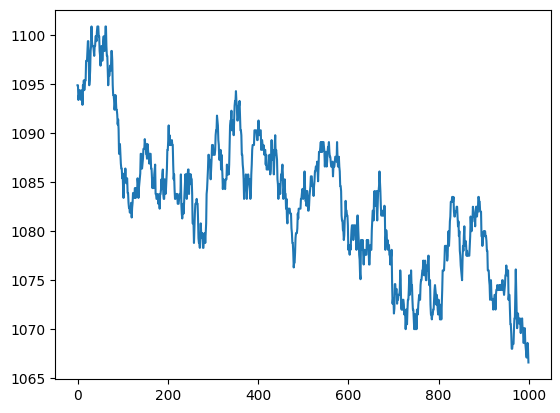

In [7]:
import matplotlib.pyplot as plt

plt.plot(result_array)
plt.show()